In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## File paths

In [2]:
data ='C:/Users/jerry/Downloads/archive'
working='C:/Users/jerry/Downloads/archive/features'

## Model for image feature extraction

In [3]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Extracting Image features 

In [4]:

features = {}
directory = os.path.join(data, 'Images')

for img_name in tqdm(os.listdir(directory)):
  
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

## Saving and loading saved features

In [5]:
pickle.dump(features, open(os.path.join(working, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(working, 'features.pkl'), 'rb') as f:features = pickle.load(f)

## Loading captions and mapping with the image

In [7]:
with open(os.path.join(data, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
    

In [8]:

mapping = {}

for line in tqdm(captions_doc.split('\n')):
	tokens = line.split(',')
    
	if len(line) < 2:
		continue
        
	image_id, caption = tokens[0], tokens[1:]
	image_id = image_id.split('.')[0]
	caption = " ".join(caption)
    
	if image_id not in mapping:
		mapping[image_id] = []

	mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Cleaning captions for model training

In [10]:
def clean(mapping):
	for key, captions in mapping.items():
		for i in range(len(captions)):
             
			caption = captions[i]
               
			caption = caption.lower()
               
			caption = caption.replace('[^A-Za-z]', '')
               
			caption = caption.replace('\s+', ' ')
                
			caption = 'start  ' + " ".join([word for word in caption.split() if len(word)>1]) + '  end'
			captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['start  child in pink dress is climbing up set of stairs in an entry way  end',
 'start  girl going into wooden building  end',
 'start  little girl climbing into wooden playhouse  end',
 'start  little girl climbing the stairs to her playhouse  end',
 'start  little girl in pink dress going into wooden cabin  end']

In [14]:
all_captions = []
for key in mapping:
	for caption in mapping[key]:
		all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8483

In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train and Test split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

##  Data generator 

In [19]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  
	X1, X2, y = list(), list(), list()
	n = 0
	while 1:
		for key in data_keys:
			n += 1
			captions = mapping[key]
			for caption in captions:
				seq = tokenizer.texts_to_sequences([caption])[0]
				for i in range(1, len(seq)):
					in_seq, out_seq = seq[:i], seq[i]
					in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
					out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
					X1.append(features[key][0])
					X2.append(in_seq)
					y.append(out_seq)
			if n == batch_size:
				X1, X2, y = np.array(X1), np.array(X2), np.array(y)
				yield [X1, X2], y
				X1, X2, y = list(), list(), list()
				n = 0

## Model creation

In [20]:
# encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
 
# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Traing the Model

In [21]:
epochs = 35
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
	generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 620s 3s/step - loss: 1.8813


In [22]:
model.save(working +'/best_model.h5')

## Caption generator

In [23]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
        	return word
    return None


In [24]:

def predict_caption(model, image, tokenizer, max_length):
	in_text = 'start'

	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], max_length)
		text = model.predict([image, sequence], verbose=0)
		text = np.argmax(text)
		word = idx_to_word(text, tokenizer)
		if word is None:
			break
		in_text += " " + word
		if word == 'end':
			break

	return in_text

#  Validating

In [25]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
	captions = mapping[key]
	y_pred = predict_caption(model, features[key], tokenizer, max_length)
	actual_captions = [caption.split() for caption in captions]
	y_pred = y_pred.split()
	actual.append(actual_captions)
	predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.542715
BLEU-2: 0.320914


## Output testing

In [26]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
	image_id = image_name.split('.')[0]
	img_path = os.path.join(data, "Images", image_name)
	image = Image.open(img_path)
	captions = mapping[image_id]
	print('---------------------Actual---------------------')
	for caption in captions:
		print(caption)
	y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
	print('--------------------Predicted--------------------')
	print(y_pred)
	plt.imshow(image)

---------------------Actual---------------------
start  little girl covered in paint sits in front of painted rainbow with her hands in bowl  end
start  little girl is sitting in front of large painted rainbow  end
start  small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it  end
start  there is girl with pigtails sitting in front of rainbow painting  end
start  young girl with pigtails painting outside in the grass  end
--------------------Predicted--------------------
start girl in pink dress is standing in front of colorful painted painting end


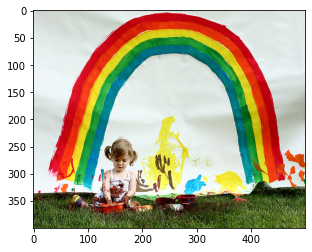

In [27]:
generate_caption("1002674143_1b742ab4b8.jpg")

#  Testing real image

In [28]:
vgg_model = VGG16() 
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

start dog is running through the water end


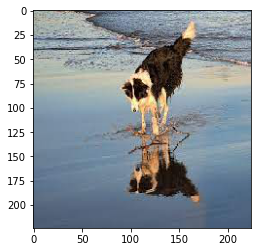

In [37]:
image_path = 'C:/Users/jerry/Downloads/image25.jpg'

image1 = load_img(image_path, target_size=(224, 224))
image = img_to_array(image1)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

feature = vgg_model.predict(image, verbose=0)

x=predict_caption(model, feature, tokenizer, max_length)

plt.imshow(image1)
print(x)